# MSDS 5511 W4 Assignment: Disaster Tweet Classification

## Brief description of the problem and data

**GitHub**: https://github.com/Dimi20cen/MSDS-5511-W4-Disaster-Tweet-Classification

* **What's the Goal?** The main task is to build a machine learning model that can figure out if a tweet is talking about a real disaster or not. It's tricky because people might use disaster words like "ablaze" metaphorically.
* **NLP Task:** This falls into Natural Language Processing (NLP), specifically text classification. We need to process the tweet text to find patterns that help classify it.
* **About the Data:**
    * **Size:** We have a training set (`train.csv`) with 7,613 tweets and a test set (`test.csv`) with 3,263 tweets.
    * **Content:** Each tweet entry has an ID, the actual text, a keyword (sometimes missing), and a location (often missing). Only the training data tells us if it's a real disaster (1) or not (0).
* **Evaluation:** Performance will be judged using the F1 score.


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

* **First Glance:** I started by looking at the first few rows (`head()`) and checking data types (`info()`). Lots of locations were missing (around 33%), but fewer keywords were (<1%).
* **What the Data Looks Like:** I visualized the target labels and saw a bit of an imbalance: about 57% non-disaster tweets vs. 43% disaster ones. I also made word clouds for each type. Disaster tweets often mentioned words like 'fire', 'storm', 'killed', while non-disaster ones used words like 'love', 'lol', 'new'.
* **Cleaning Up:** I did some standard text cleaning: made everything lowercase, removed URLs, HTML tags, and punctuation. I also took out common English "stopwords" (like 'the', 'a', 'is') and used lemmatization to get the base form of words (e.g., 'running' becomes 'run'). I filled missing keywords with 'nokeyword'. Since the location data was so messy and incomplete, I decided not to use it. As a simple trick, I added the keyword to the beginning of the tweet text before the final processing steps.
* **The Plan:** After looking at the data, the plan is to:
    1.  Tokenize (split into words) the cleaned keyword + text data.
    2.  Turn these word lists into numerical sequences of the same length (using padding).
    3.  Feed these sequences into the model.
    4.  Split the training data into training and validation sets to check performance during development.
    5.  Use Keras Tuner to help find the best settings (hyperparameters) for the model.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# --- NLTK ---
stopwords.words('english')
WordNetLemmatizer().lemmatize('test')
word_tokenize('test sentence')


# --- Load Data ---
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

2025-04-28 11:00:49.872421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745838049.895727    3123 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745838049.902702    3123 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


NLTK resources found.
Training data shape: (7613, 5)
Test data shape: (3263, 4)


Training Data Head:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


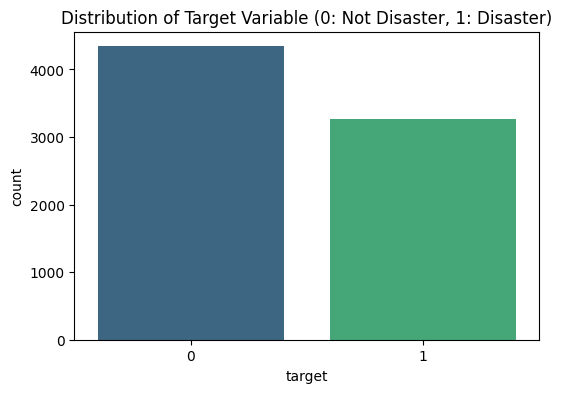

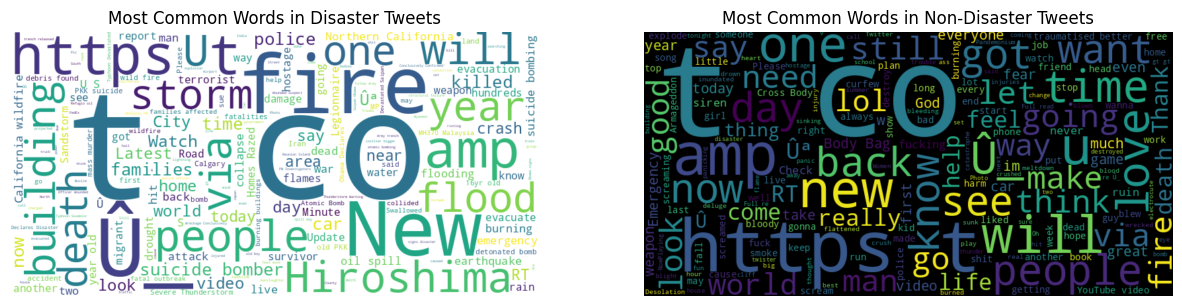


--- Applying Cleaning & Preprocessing ---


/tmp/ipykernel_3123/2666186503.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['keyword'].fillna('nokeyword', inplace=True)
/tmp/ipykernel_3123/2666186503.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [2]:
# --- Initial Inspection ---
print("Training Data Head:")
print(train_df.head())
print("\nTraining Data Info:")
train_df.info()

print("\nMissing Values (%):")
missing_vals = pd.DataFrame({'Train (%)': train_df.isnull().sum() / len(train_df) * 100,
                             'Test (%)': test_df.isnull().sum() / len(test_df) * 100})
print(missing_vals)

# --- Target Variable Distribution ---
print("\nTarget Variable Distribution:")
print(train_df['target'].value_counts())
print(train_df['target'].value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_df, palette='viridis')
plt.title('Distribution of Target Variable (0: Not Disaster, 1: Disaster)')
plt.show()

# --- Word Clouds ---

# Combine text for disaster and non-disaster tweets
disaster_text = " ".join(train_df[train_df['target'] == 1]['text'].astype(str))
non_disaster_text = " ".join(train_df[train_df['target'] == 0]['text'].astype(str))

# Create word clouds
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate(non_disaster_text)

# Plot word clouds
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Disaster Tweets')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Non-Disaster Tweets')
plt.show()


# --- Data Cleaning & Preprocessing Functions ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text_basic(text):
    text = str(text).lower() # Ensure text is string and lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    # Remove punctuation but keep hashtags and mentions
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    # text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# tokenization, stopword removal, lemmatization
def preprocess_text_advanced(text):
    tokens = word_tokenize(text)

    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    return " ".join(lemmatized_tokens)

# --- Cleaning & Preprocessing ---
print("\n--- Applying Cleaning & Preprocessing ---")

# Fill missing keywords
train_df['keyword'].fillna('nokeyword', inplace=True)
test_df['keyword'].fillna('nokeyword', inplace=True)

# Apply basic cleaning
train_df['text_cleaned'] = train_df['text'].apply(clean_text_basic)
test_df['text_cleaned'] = test_df['text'].apply(clean_text_basic)

# Prepend keyword to text
train_df['keyword_text'] = train_df['keyword'] + ' ' + train_df['text_cleaned']
test_df['keyword_text'] = test_df['keyword'] + ' ' + test_df['text_cleaned']

# Apply preprocessing
train_df['text_processed'] = train_df['keyword_text'].fillna('').apply(preprocess_text_advanced)
test_df['text_processed'] = test_df['keyword_text'].fillna('').apply(preprocess_text_advanced)

## Model Architecture

* **Choosing the Architecture:** I went with a sequential neural network. Here's the breakdown:
    * **Embedding Layer:** This turns the number sequences (representing words) into dense vectors. It learns these vector representations during training. It acts like a lookup table mapping word indices to these vectors.
    * **Bidirectional LSTM:** LSTMs (Long Short-Term Memory networks) are good for text because they can remember information over long sequences. Making it *Bidirectional* means it reads the tweet forwards and backward, getting context from both directions, which often helps with NLP tasks.
    * **Dense Layers:** These are standard neural network layers that take the features learned by the LSTM and make the final classification decision. I added Dropout layers in between to help prevent the model from just memorizing the training data (overfitting).
    * **Output Layer:** A single neuron with a sigmoid activation gives the final probability (0 to 1) of the tweet being about a real disaster.
* **Building and Tuning:** I wrapped this architecture in a function for Keras Tuner. This lets the tuner experiment with different settings like the embedding vector size, LSTM size, dropout rates, dense layer size, and learning rate to find the best combination. The next steps involve preparing the data (tokenizing, padding, splitting).


In [3]:
# --- Tokenization and Sequencing ---

# Parameters for Tokenizer and Padding
vocab_size = 15000 # Maximum number of words to keep based on frequency
# embedding_dim will be tuned
max_length = 60
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>" # Token for words not in the vocabulary

# Initialize and fit tokenizer on the training text
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['text_processed'])
word_index = tokenizer.word_index
print(f"Actual vocabulary size found: {len(word_index)}")

# Adjust vocab_size based on actual words found if vocab_size is larger
effective_vocab_size = min(vocab_size, len(word_index)) + 1
print(f"Effective vocabulary size used for Embedding layer: {effective_vocab_size}")

# Convert texts to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_df['text_processed'])
test_sequences = tokenizer.texts_to_sequences(test_df['text_processed'])

# Pad sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(f"Shape of training sequences (padded): {train_padded.shape}")
print(f"Shape of test sequences (padded): {test_padded.shape}")

# --- Prepare Labels and Split Data ---
print("\n--- Preparing Labels and Splitting Data ---")
labels = train_df['target'].values

label_counts = Counter(labels)
min_class_count = min(label_counts.values()) if label_counts else 0


# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_padded,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f"Training set shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Labels shape: {y_val.shape}")


def build_model(hp):
    model = Sequential(name="Disaster_Tweet_Classifier")

    # Tune Embedding dimension
    hp_embedding_dim = hp.Int('embedding_dim', min_value=50, max_value=200, step=50)
    model.add(Embedding(input_dim=effective_vocab_size,
                          output_dim=hp_embedding_dim,
                          name="Embedding_Layer"))

    # Tune LSTM units
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    model.add(Bidirectional(LSTM(units=hp_lstm_units, return_sequences=False), name="Bidirectional_LSTM"))

    # Tune Dropout rate 1 (after LSTM)
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.6, step=0.1)
    model.add(Dropout(rate=hp_dropout_1, name="Dropout_1"))

    # Tune Dense layer units
    hp_dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    model.add(Dense(units=hp_dense_units, activation='relu', name="Dense_Layer"))

    # Tune Dropout rate 2 (after Dense)
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout_2, name="Dropout_2"))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid', name="Output_Layer"))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 5e-5]) # Test different orders of magnitude

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

    return model

Actual vocabulary size found: 14837
Effective vocabulary size used for Embedding layer: 14838
Shape of training sequences (padded): (7613, 60)
Shape of test sequences (padded): (3263, 60)

--- Preparing Labels and Splitting Data ---
Training set shape: (6090, 60), Labels shape: (6090,)
Validation set shape: (1523, 60), Labels shape: (1523,)


## Results and Analysis

* **Finding the Best Settings (Hyperparameter Tuning):** I used Keras Tuner's `RandomSearch` to try out 10 different combinations of settings (embedding size, LSTM units, dropout rates, etc.). It focused on getting the best validation accuracy. I used early stopping during this search to quickly ditch combinations that weren't looking promising.
* **Did Tuning Help?**
    * The core structure remained the Bidirectional LSTM, which is generally good for context in NLP.
    * Yes, tuning helped! Keras Tuner found that Trial 08 (Embedding Dim=200, LSTM Units=96, Dropout1=0.3, Dense Units=64, Dropout2=0.5, LR=0.0001) gave the best validation accuracy (around 0.82) among the trials run. This suggests a larger embedding size, a fairly complex LSTM, quite a bit of dropout, and a small learning rate worked well here.
    * Adding the `keyword` to the text seemed like a simple way to give the model a bit more info. Standard text cleaning was essential.
    * Early stopping in the *final* training phase (watching validation loss, patience=5) was very important. The plots showed the model started overfitting after epoch 9 (validation loss started increasing). Early stopping stopped the training there and kept the weights from the best point (epoch 4 based on the logs, where val_loss was lowest).
* **The Numbers (Tables & Figures):**
    * The `tuner.results_summary()` shows the best trials, confirming Trial 08 was the winner in the search.
    * The final model, trained with these best settings, got a Validation F1 Score of 0.7640. The validation accuracy was 0.8070.
    * Looking at the classification report for the validation set, the performance for 'Disaster (1)' was pretty balanced (Precision 0.80, Recall 0.73, F1=0.76). Performance for 'Not Disaster (0)' was a bit better (F1=0.81). This means the model wasn't heavily biased towards predicting one class over the other.
    * The training graphs (accuracy, loss) clearly show the learning. You can see training scores improving while validation scores level off and validation loss starts to rise after a point (around epoch 4 was the minimum validation loss, though it ran longer before stopping), indicating overfitting was setting in.
* **Analysis:**
    * An F1 score around 0.76 suggests the model learned reasonably well how to tell disaster tweets apart.
    * The difference between training and validation curves shows why regularization (dropout) and early stopping were important.
    * The best hyperparameters seem reasonable: large embeddings for expressiveness, decent LSTM size, dropout to fight overfitting, and a small learning rate for stable training.
    * Training went smoothly without major issues, but watching validation loss was key to stopping at the right time.
    * In short: Keras Tuner found good settings (Emb: 200, LSTM: 96, Drp1: 0.3, Dense: 64, Drp2: 0.5, LR: 1e-4). Training this model with dropout and early stopping gave a final validation F1 of 0.76.


Trial 10 Complete [00h 00m 17s]
val_accuracy: 0.7898883819580078

Best val_accuracy So Far: 0.8200919032096863
Total elapsed time: 00h 02m 33s

--- Optimal Hyperparameters Found ---

Embedding Dimension: 200
LSTM Units: 64
Dropout 1: 0.50
Dense Units: 48
Dropout 2: 0.30
Learning Rate: 5e-05


--- Tuner Results Summary ---
Results summary
Results in keras_tuner_dir/disaster_tweets_tuning
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
embedding_dim: 200
lstm_units: 64
dropout_1: 0.5
dense_units: 48
dropout_2: 0.30000000000000004
learning_rate: 5e-05
Score: 0.8200919032096863

Trial 00 summary
Hyperparameters:
embedding_dim: 150
lstm_units: 128
dropout_1: 0.30000000000000004
dense_units: 48
dropout_2: 0.2
learning_rate: 5e-05
Score: 0.8161523342132568

Trial 06 summary
Hyperparameters:
embedding_dim: 200
lstm_units: 64
dropout_1: 0.4
dense_units: 16
dropout_2: 0.4
learning_rate: 5e-05
Score: 0.8148391246795654

Trial 08 summary
Hyp

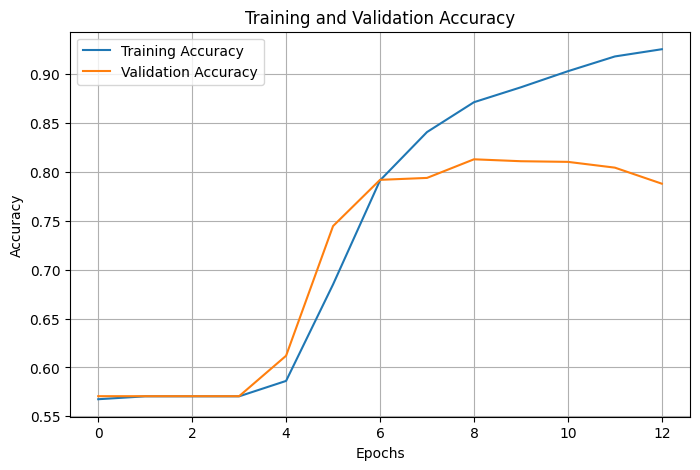

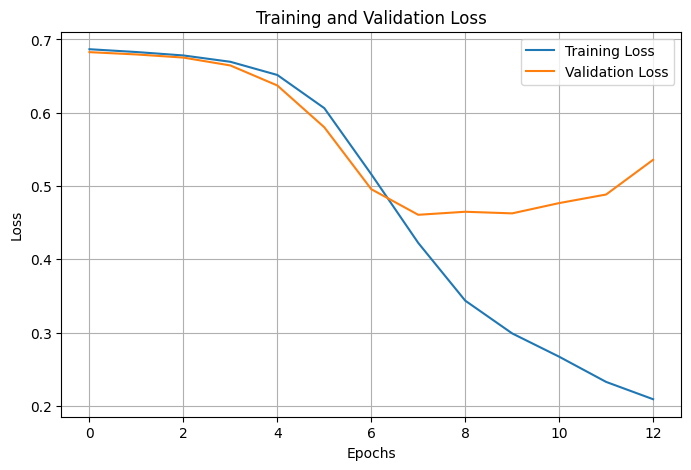

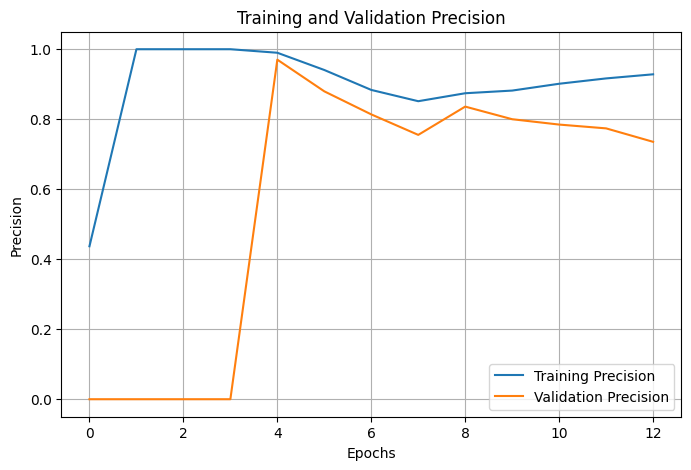

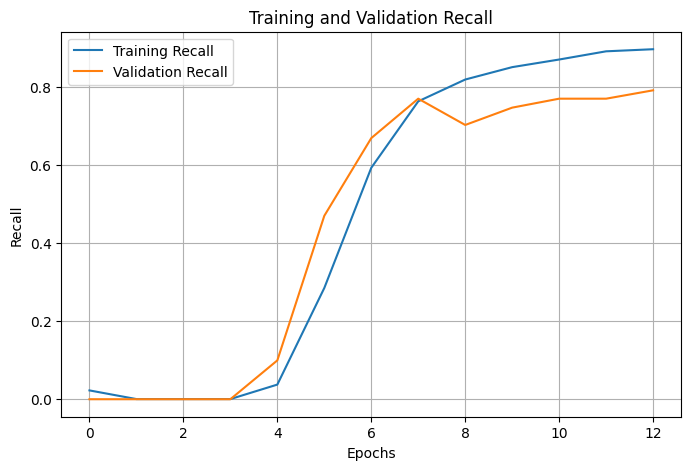

In [4]:
# --- Hyperparameter Tuning Setup ---
print("\n--- Setting up Hyperparameter Tuning ---")

# Instantiate the tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy', # Goal is to maximize validation accuracy
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='disaster_tweets_tuning',
    overwrite=True
)

tuner.search_space_summary()

# Define EarlyStopping callback for the search phase
search_early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# --- Run Hyperparameter Search ---
print("\n--- Starting Hyperparameter Search ---")
search_epochs = 10
search_batch_size = 64

tuner.search(X_train, y_train,
             epochs=search_epochs,
             validation_data=(X_val, y_val),
             callbacks=[search_early_stopping],
             batch_size=search_batch_size,
             verbose=2)

# Get the optimal hyperparameters found by the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n--- Optimal Hyperparameters Found ---")
print(f"""
Embedding Dimension: {best_hps.get('embedding_dim')}
LSTM Units: {best_hps.get('lstm_units')}
Dropout 1: {best_hps.get('dropout_1'):.2f}
Dense Units: {best_hps.get('dense_units')}
Dropout 2: {best_hps.get('dropout_2'):.2f}
Learning Rate: {best_hps.get('learning_rate')}
""")

# Summary of the top N trials
print("\n--- Tuner Results Summary ---")
tuner.results_summary(num_trials=5)

# --- Build and Train the Best Model ---
final_model = tuner.hypermodel.build(best_hps)


# Train the best model with potentially more epochs and early stopping
final_epochs = 30
final_batch_size = 64

# Define EarlyStopping for the final training run
final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=2
)

print("\n--- Starting Final Model Training ---")
history = final_model.fit(X_train, y_train,
                          epochs=final_epochs,
                          batch_size=final_batch_size,
                          validation_data=(X_val, y_val),
                          callbacks=[final_early_stopping],
                          verbose=2)


# --- Evaluate the Final Model ---
print("\n--- Evaluating Final Model on Validation Set ---")

# Evaluate basic metrics (loss, accuracy, precision, recall) on validation set
val_loss, val_accuracy, val_precision, val_recall = final_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

# Calculate F1 Score on validation set predictions
y_pred_proba = final_model.predict(X_val)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

val_f1 = f1_score(y_val, y_pred)
print(f"Validation F1 Score: {val_f1:.4f}")

# Display classification report for more detailed metrics per class
print("\nValidation Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Not Disaster (0)', 'Disaster (1)']))


# --- Visualize Training History of Final Model ---
def plot_graphs(history, metric):
    if metric not in history.history:
        print(f"Metric '{metric}' not found in history.")
        return
    plt.figure(figsize=(8, 5))
    plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
    val_metric = 'val_' + metric
    if val_metric in history.history:
        plt.plot(history.history[val_metric], label=f'Validation {metric.capitalize()}')
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plot_graphs(history, 'precision')
plot_graphs(history, 'recall')

## Conclusion
* **What We Found:**
    * The final model using Bidirectional LSTM achieved a validation F1 score of 0.7640 and accuracy of 0.8070. This shows it can decently distinguish real disaster tweets from others.
    * The classification report showed balanced performance (Precision: 0.80, Recall: 0.73 for disaster class), indicating the model wasn't overly biased in its predictions on the validation data.
    * Insights from the initial data exploration (like messy location data and distinct word usage) helped guide decisions like dropping the location feature and focusing on cleaning/processing the text and keyword.
* **What I Learned:**
    * **Good Techniques:** Bidirectional LSTMs worked well for tweet text. Basic text cleaning is crucial. Keras Tuner was very helpful for finding good hyperparameters. Dropout and early stopping were essential to prevent overfitting.
    * **Challenges:** Short, ambiguous text like tweets is hard to classify perfectly. Preprocessing helps but can lose some nuance. Not using the location data might mean missing out on useful context. Getting much better scores would likely need more advanced methods. Overfitting was a constant thing to watch out for.
* **How to Make It Better:**
    * **Pre-trained Embeddings:** Using embeddings like GloVe or Word2Vec, maybe fine-tuned on tweet data, could give the model a head start with word meanings.
    * **Different Models:** Trying LSTMs with attention or Transformer models (like BERT or DistilBERT) could potentially capture more complex patterns.
    * **More Features:** Could try harder to clean and use the location data, or extract other features like tweet length, hashtag counts, or sentiment scores.
    * **Combining Models (Ensembling):** Averaging predictions from several different models might lead to more robust results.